# Human Activity Recognition using Clustering


**Integrantes:**
- Lucas Carranza
- Guillermo Sánchez
- David Herencia
- José Osnayo

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import glob

## Dataset Analysis

### Lectura de los csv
Leemos los archivos .csv que contienen el id único de cada video, y la clase correspondiente para el entrenamiento y validación.

In [6]:
train_path = "data/train_subset_10.csv"
val_path = "data/val_subset_10.csv"
test_path = "data/test_subset_10.csv"

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)
train_df.head()

,youtube_id,label
0,zeIkGEHK46I,riding camel
1,-Fwy8NwefTk,shot put
2,sDD0p8h88rI,dying hair
3,09AinCnKAE8,riding camel
4,qyTDZajMSqQ,baking cookies


### Análisis de Frecuencias

Analizamos las frecuencias de las apariciones de las clases en la data de entrenamiento para saber si requerimos de consideraciones especiales por desbalanceo.

Observamos que la data de validación se encuentra bien balanceada, mientras que la data de entrenamiento no lo está. El ratio de frecuencias entre la clase con más apariciones 'dying hair' y la clase con menos apariciones 'spraying' es de 2.75 a 1 aproximadamente.

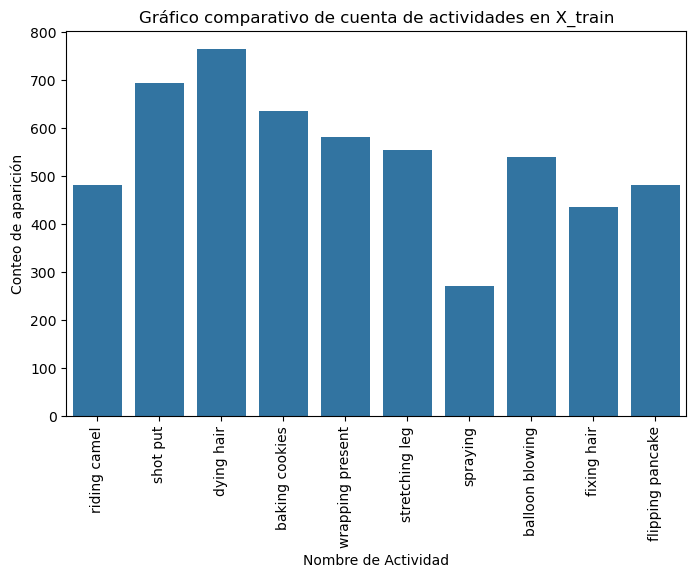

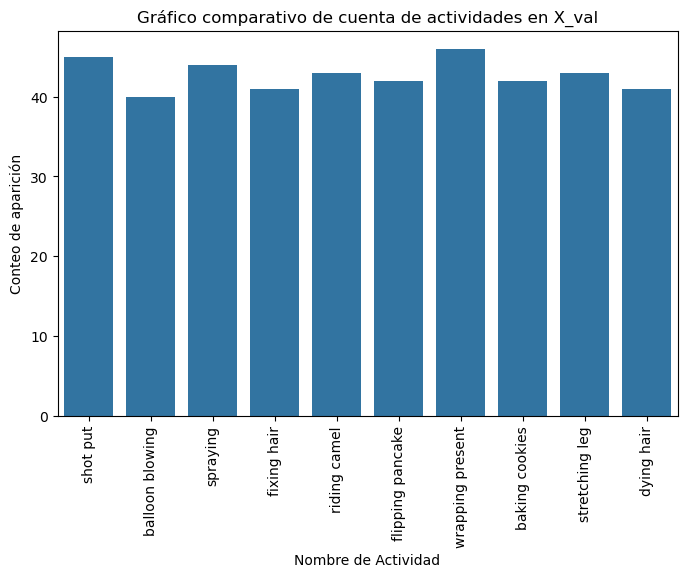

In [7]:
plt.figure(figsize=(8,5))
sns.countplot(x='label', data=train_df)
plt.xticks(rotation='vertical')
plt.title('Gráfico comparativo de cuenta de actividades en X_train')
plt.xlabel('Nombre de Actividad')
plt.ylabel('Conteo de aparición')

plt.figure(figsize=(8,5))
sns.countplot(x='label', data=val_df)
plt.xticks(rotation='vertical')
plt.title('Gráfico comparativo de cuenta de actividades en X_val')
plt.xlabel('Nombre de Actividad')
plt.ylabel('Conteo de aparición')


plt.show()

### Extracción de Features

Utilizamos la librería video_features para extraer el vector característico de cada video, utilizando el modelo R(2+1)D que está especializado en el reconocimiento de actividades.
Para esto necesitamos generar un archivo de texto que contenga las rutas de archivo a cada video a procesar.

In [8]:
# # Script para recortar los nombres de cada video a unicamente el id
# for directory in ['./data/train_subset', './data/test_subset', './data/val_subset']:
#     changed_count = 0
#     for filename in os.listdir(directory):
#         if filename.endswith(".mp4") and '_' in filename:
#             youtube_id = filename.split('_')[0]
#             new_filename = f"{youtube_id}.mp4"
#             old_file = os.path.join(directory, filename)
#             new_file = os.path.join(directory, new_filename)
            
#             ''' DESCOMENTAR PARA EJECUTAR CAMBIOS '''
#             # os.rename(old_file, new_file) 
#             # changed_count += 1
    
#     print(f"Renaming process for {directory} completed. Updated {changed_count} file names")

Renaming process for ./data/train_subset completed. Updated 0 file names
Renaming process for ./data/test_subset completed. Updated 0 file names
Renaming process for ./data/val_subset completed. Updated 0 file names


In [20]:
# # Script para guardar las rutas de los videos en un archivo .txt
# paths = []
# directory = '/home/lucas/projects/jupyter_nb/HAClustering/data/'
# # for youtube_id in train_df['youtube_id']:
#     # paths.append(os.path.join(directory, f"train_subset/{youtube_id}.mp4"))
# for youtube_id in val_df['youtube_id']:
#     paths.append(os.path.join(directory, f"val_subset/{youtube_id}.mp4"))
# for youtube_id in test_df['youtube_id']:
#     paths.append(os.path.join(directory, f"test_subset/{youtube_id}.mp4"))

# # write to .txt
# output_file = './data/paths.txt'
# with open(output_file, 'w') as f:
#     for path in paths:
#         ''' DESCOMENTAR PARA EJECUTAR CAMBIOS '''
#         f.write(f"{path}\n")

# print("Finished writing video paths")

Finished writing video paths


Una vez que ejecutamos el código de la librería video_features y procesamos cada video pot el modelo R(2+1)D, obtenemos una serie de vectores característicos almacenados en un archivo de numpy (.npy), donde cada video tiene su archivo correspondiente. Cada vector característico tiene el formato `{youtube_id}_r21d.npy`.

Leemos y procesamos cada vector característico para almacenarlo en un nuevo dataframe, y eliminamos aquellos vectores que hayan 

In [23]:
feature_path = './r2plus1d_ig65m'

def consolidate_features(path, df, return_labels=True):
    features = []
    labels = []
    ids = []
    invalid = 0
    for video in glob.glob(os.path.join(path, '*.npy')):
        youtube_id = os.path.basename(video).split('_')[0]
        current = np.load(video)
        # Skip videos not in df
        if youtube_id not in df['youtube_id'].values:
            continue
        # skip invalid videos
        if current.size == 0:
            invalid += 1
            continue
        features.append(np.mean(current, axis = 0))
        ids.append(youtube_id)
        if return_labels:
            labels.append(df[df['youtube_id'] == youtube_id]['label'].values[0])
    print("# Vectores invalidos: ", invalid)
    features = pd.DataFrame(np.vstack(features))
    ids = pd.DataFrame({'youtube_id': ids})
    
    if return_labels:
        labels = pd.DataFrame(np.vstack(labels))
        return features, labels, ids
    else:
        return features, ids

In [24]:
X_train, Y_train, train_ids = consolidate_features(feature_path, train_df)
X_val, Y_val, val_ids = consolidate_features(feature_path, val_df)
X_test, test_ids = consolidate_features(feature_path, test_df, return_labels=False)
print("Finished consolidating feature vectors")
X_train.head()

# Vectores invalidos:  6
# Vectores invalidos:  0
# Vectores invalidos:  1
Finished consolidating feature vectors


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.102995,1.374283,0.645592,0.360117,1.219178,1.971797,0.296096,0.877572,2.454623,0.058088,...,3.323919,1.096497,1.634622,1.196886,0.059341,0.767414,0.175689,0.691067,0.791807,0.842487
1,0.099195,1.222913,0.019773,0.474842,0.565512,1.689187,0.532217,0.753887,1.731134,0.005336,...,0.989794,0.353828,2.438806,0.416004,0.138337,0.932616,0.125756,0.304078,0.318861,1.462174
2,2.200152,0.603164,0.332472,1.089014,0.424194,0.677416,0.494241,0.142152,1.667272,0.047816,...,0.972476,0.745196,0.917795,0.228072,0.973380,0.991138,1.279901,0.349011,0.706344,2.392532
3,0.063865,1.581963,0.601078,1.447111,0.094283,0.345464,0.516052,0.065103,0.212830,1.858803,...,1.168467,0.285927,0.420671,0.689702,1.286480,1.362151,1.882433,0.624955,0.970263,0.973123
4,0.112106,1.020166,0.463630,0.394868,0.714069,0.840226,0.588462,1.596407,3.017711,0.080310,...,2.907753,0.386094,1.921593,1.350581,0.266198,1.619764,0.040388,0.681664,0.268891,0.924654


In [67]:
print("feature vectors  : ", len(X_train) + len(X_val) + len(X_test))
print("original csv len : ", len(train_df) + len(val_df) + len(test_df))
missing_train = len(train_df) - len(X_train)
missing_val = len(val_df) - len(X_val)
missing_test = len(test_df) - len(X_test)
print("missing_train: ", missing_train)
print("missing_val: ", missing_val)
print("missing_test: ", missing_test)

feature vectors  :  6639
original csv len :  6664
missing_train:  23
missing_val:  1
missing_test:  1


## Reducción de Dimensionalidad

### Normalización

Probamos con distintos algoritmos de normalización de la libería scikit-learn para comprobar el impacto de estos en la calidad de los clusters generados al reducir la dimensionalidad.

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

# scaler = StandardScaler()
scaler = PowerTransformer(method='yeo-johnson')
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [27]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
train_numeric_labels, _ = pd.factorize(Y_train[0])
val_numeric_labels, _ = pd.factorize(Y_val[0])

### Sin Reducción:

Probamos la calidad de los clusters antes de la reducción de dimensionalidad, como benchmark para medir la pérdida de calidad al aplicarle los demás algoritmos.

In [28]:
print(f"Number of features: {X_train_scaled.shape[1]}")

silhouette_train = silhouette_score(X_train_scaled, train_numeric_labels)
silhouette_val = silhouette_score(X_val_scaled, val_numeric_labels)

print(f"Silhouette Score for Training Data: {silhouette_train}")
print(f"Silhouette Score for Validation Data: {silhouette_val}")

Number of features: 512
Silhouette Score for Training Data: 0.37410259042375044
Silhouette Score for Validation Data: 0.3014258174299176


### PCA:
Probamos con el algoritmo de PCA para reducir la dimensionalidad de los vectores característicos, con el fin de hallar el número de componentes necesarios para explicar el 95% de la varianza.

Comprobamos como se ven los clusters tras realizar la reducción de Dimensionalidad, y obtenemos las puntuaciones de sus métricas.

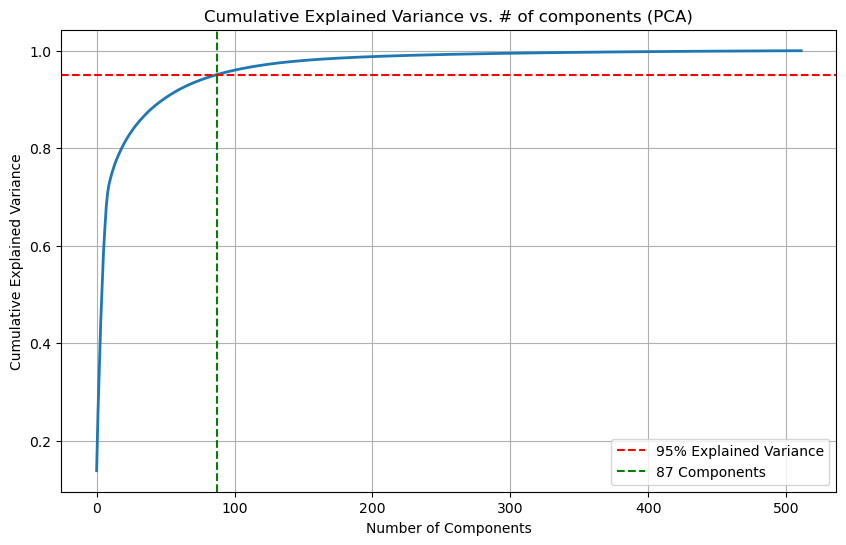

In [29]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)
k_pca = np.argmax(cumsum >= 0.95)

plt.figure(figsize=(10, 6))
plt.plot(cumsum, linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axvline(x=k_pca, color='g', linestyle='--', label=f'{k_pca} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. # of components (PCA)')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
pca2 = PCA(k_pca)
X_train_pca = pca2.fit_transform(X_train_scaled)
X_val_pca = pca2.transform(X_val_scaled)
X_test_pca = pca2.transform(X_test_scaled)

Number of features: 87
Silhouette Score for Training Data: 0.40184574753956853
Silhouette Score for Validation Data: 0.32780517717880286


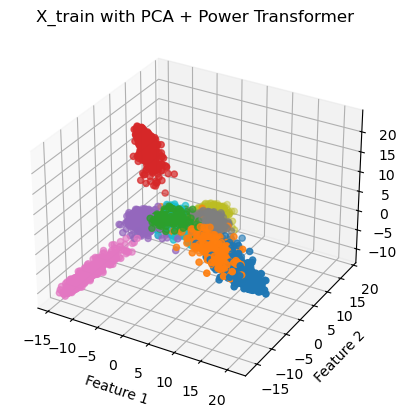

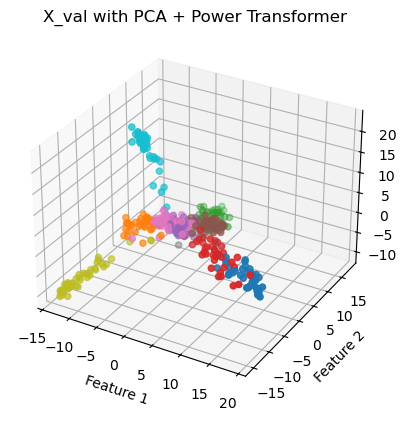

In [32]:
print(f"Number of features: {X_train_pca.shape[1]}")

silhouette_train = silhouette_score(X_train_pca, train_numeric_labels)
silhouette_val = silhouette_score(X_val_pca, val_numeric_labels)

print(f"Silhouette Score for Training Data: {silhouette_train}")
print(f"Silhouette Score for Validation Data: {silhouette_val}")

# Plot for X_train
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=train_numeric_labels, cmap='tab10')
ax.set_title("X_train with PCA + Power Transformer")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.show()

# Plot for X_val
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_val_pca[:, 0], X_val_pca[:, 1], X_val_pca[:, 2], c=val_numeric_labels, cmap='tab10')
ax.set_title("X_val with PCA + Power Transformer")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.show()

### UMAP:

Probamos con el algoritmo UMAP para reducir la dimensionalidad drásticamente y separar bien los clústers. Se puede reducir a 2 o 3 dimensiones para permitir la visualización, o se puede mantener más dimensionalidad para mejorar la precisión de los clusters, lo cual es necesario para los métodos por densidad como DBSCAN

Librería: [umap-learn](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)

In [161]:
from umap import UMAP

n_neighbors = 25
min_dist = 0.075
n_components = 50
metric = "euclidean"
umap = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=777, metric=metric, n_jobs=1)
X_train_umap = umap.fit_transform(X_train_scaled)
X_val_umap = umap.transform(X_val_scaled)
X_test_umap = umap.transform(X_test_scaled)

Number of features: 50
Silhouette Score for Training Data: 0.824552059173584
Silhouette Score for Validation Data: 0.7862948775291443


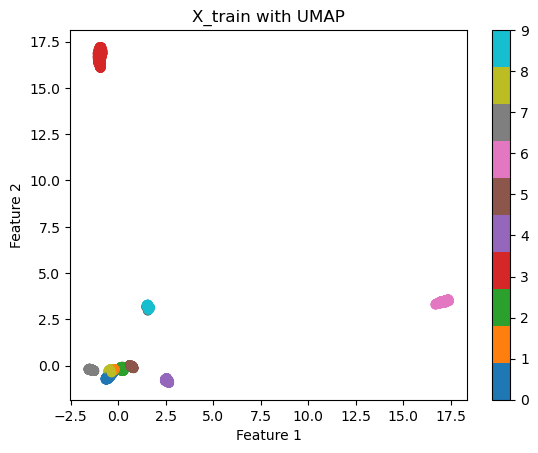

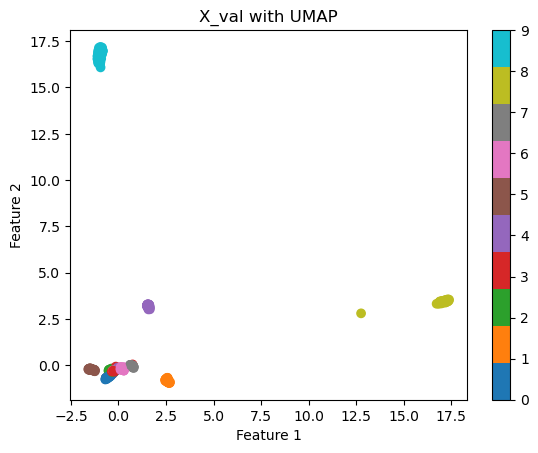

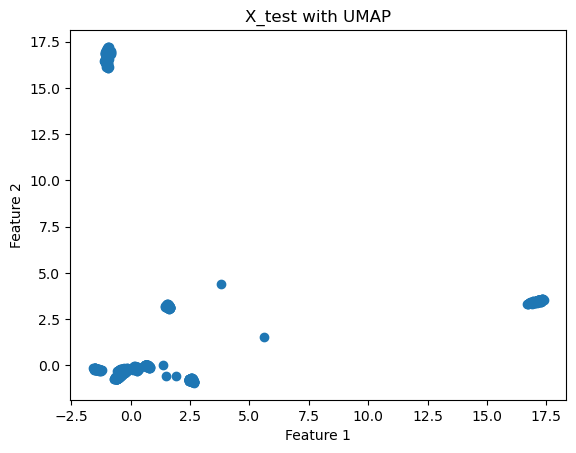

In [162]:
print(f"Number of features: {X_train_umap.shape[1]}")

silhouette_train = silhouette_score(X_train_umap, train_numeric_labels)
silhouette_val = silhouette_score(X_val_umap, val_numeric_labels)

print(f"Silhouette Score for Training Data: {silhouette_train}")
print(f"Silhouette Score for Validation Data: {silhouette_val}")

# Plot for X_train
fig = plt.figure()
numeric_labels, _ = pd.factorize(Y_train[0])
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=numeric_labels, cmap='tab10')
plt.title("X_train with UMAP")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.show()


# Plot for X_val
fig = plt.figure()
numeric_labels, _ = pd.factorize(Y_val[0])
plt.scatter(X_val_umap[:, 0], X_val_umap[:, 1], c=numeric_labels, cmap='tab10')
plt.title("X_val with UMAP")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.show()

# Plot for X_test
fig = plt.figure()
numeric_labels, _ = pd.factorize(Y_val[0])
plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1])
plt.title("X_test with UMAP")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

## Implementación

La implementación de los Modelos de Clustering a usar

### Modelo 1: KMeans

Implementamos el modelo KMeans para clusterización con la implementación propia realizada en clase. Esta función retorna las coordenadas de los centroides, así como una lista con los clusters de cada dato.

Para la experimentación probamos con la reducción de dimensionalidad más efectiva (UMAP)

In [39]:
def distance(v1, v2):
    return np.linalg.norm(v1-v2)

def init_Centroide(data, k):
    np.random.seed(737)
    indices = np.random.choice(len(data), k, replace=False)
    return data[indices]

def return_new_centroide(grupos, data, k):
    new_centroides = []
    for clase in range(k):
        cluster_data = data[grupos == clase]
        if len(cluster_data) > 0:
            new_centroides.append(np.mean(cluster_data, axis=0))
        else:
            new_centroides.append(data[np.random.randint(len(data))])
    return np.array(new_centroides)

def get_cluster(data, centroides):
    grupos = np.zeros(len(data))
    for i in range(len(data)):
      distancias = np.zeros(len(centroides))
      for clase in range(len(centroides)):
        distancias[clase] = distance(data[i], centroides[clase])
      grupos[i] = np.argmin(distancias)
    return grupos

def distancia_promedio_centroides(old_centroides, new_centroides):
    # Initialize array of distances
    promedios = []
    # Iterate each
    for i in range(old_centroides.shape[0]):
        # Get distance between them
        dist = distance(old_centroides[i], new_centroides[i])
        # Append to mean
        promedios.append(dist)
    # Return mean value
    return np.mean(promedios)

def kmeans_train(data, k, umbral):
  centroides =  init_Centroide(data, k)
  clusters   =  get_cluster(data,centroides)
  new_centroides = return_new_centroide(clusters, data, k)
  while(distancia_promedio_centroides(centroides, new_centroides) > umbral):
     centroides = new_centroides
     clusters   =  get_cluster(data,centroides)
     new_centroides = return_new_centroide(clusters, data, k)

  return new_centroides, clusters

def kmeans_predict(data, centroides):
    clusters = get_cluster(data, centroides)
    return clusters

In [177]:
# Ejecución del modelo KMeans
umbral = 1e-6
centroides_train, kmeans_train_labels = kmeans_train(X_train_umap, 10, umbral)
kmeans_val_labels = kmeans_predict(X_val_umap, centroides_train)
kmeans_test_labels = kmeans_predict(X_test_umap, centroides_train)
print(np.unique(kmeans_train_labels, return_counts=True))
print(np.unique(kmeans_val_labels, return_counts=True))
print(np.unique(kmeans_test_labels, return_counts=True))

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([ 268,  304, 1219,  243,  230,  478,  180, 1308,  543,  636]))
(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([ 19,  23,  85,  12,  15,  43,  14, 131,  42,  42]))
(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([ 24,  49, 164,  29,  29,  84,  27, 232,  77,  89]))


Silhouette Score for Training Data: 0.666547954082489
Silhouette Score for Validation Data: 0.6353499889373779
Silhouette Score for Test Data: 0.6353499889373779
Adjusted Rand Index for Training Data: 0.6434839796965403
Adjusted Rand Index for Validation Data: 0.5687095077975127


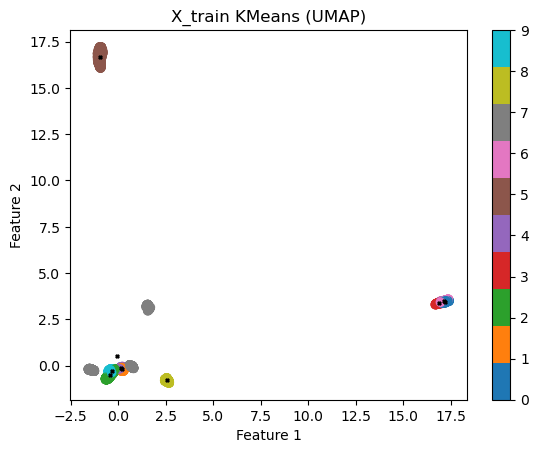

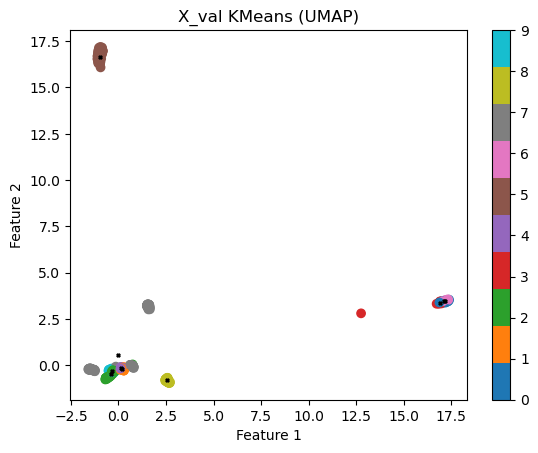

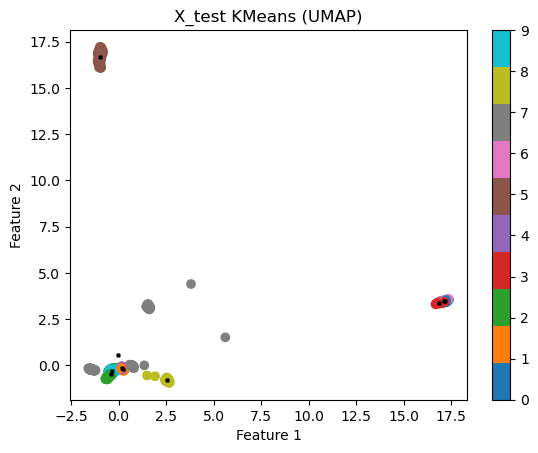

In [178]:

silhouette_train = silhouette_score(X_train_umap, kmeans_train_labels)
silhouette_val = silhouette_score(X_val_umap, kmeans_val_labels)
silhouette_val = silhouette_score(X_test_umap, kmeans_test_labels)
rand_index_train = adjusted_rand_score(Y_train[0], kmeans_train_labels)
rand_index_val = adjusted_rand_score(Y_val[0], kmeans_val_labels)

print(f"Silhouette Score for Training Data: {silhouette_train}")
print(f"Silhouette Score for Validation Data: {silhouette_val}")
print(f"Silhouette Score for Test Data: {silhouette_val}")
print(f"Adjusted Rand Index for Training Data: {rand_index_train}")
print(f"Adjusted Rand Index for Validation Data: {rand_index_val}")

# Plot for X_train
fig = plt.figure()
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=kmeans_train_labels, cmap='tab10')
plt.title("X_train KMeans (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.scatter(centroides_train[:, 0], centroides_train[:, 1], c='black', marker='X', s=5)
plt.show()


# Plot for X_val
fig = plt.figure()
plt.scatter(X_val_umap[:, 0], X_val_umap[:, 1], c=kmeans_val_labels, cmap='tab10')
plt.title("X_val KMeans (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.scatter(centroides_train[:, 0], centroides_train[:, 1], c='black', marker='X', s=5)
plt.show()

# Plot for X_val
fig = plt.figure()
plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=kmeans_test_labels, cmap='tab10')
plt.title("X_test KMeans (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.scatter(centroides_train[:, 0], centroides_train[:, 1], c='black', marker='X', s=5)
plt.show()

### Modelo 2: KMeans Mejorado

Implementamos el modelo KMeans para clusterización con la implementación propia realizada en clase. Esta función retorna las coordenadas de los centroides, así como una lista con los clusters de cada dato.

Para la experimentación probamos con la reducción de dimensionalidad más efectiva (UMAP)

In [42]:
class KMeansMejorado:
    def __init__(self, data, labels, k, umbral):
        self.umbral = umbral
        self.k = k
        self.centroides = self.init_centroide_mejorado(data, labels)
        self.clusters = self.get_cluster(data)
        new_centroides = self.return_new_centroide(data)
        while(self.distancia_promedio_centroides(new_centroides) > self.umbral):
            self.centroides = new_centroides
            self.clusters = self.get_cluster(data)
            new_centroides = self.return_new_centroide(data)

    def fetch_cluster_data(self):
        return self.centroides, self.clusters
    
    def distance(self, v1, v2):
        return np.linalg.norm(v1-v2)
    
    def init_centroide_mejorado(self, data, labels):
        centroides = []
        clases = []
        i = 0
        while len(centroides) < self.k:
            if not labels[i] in clases:
                clases.append(labels[i])
                centroides.append(data[i])
            i += 1
        return np.array(centroides)
            
    def return_new_centroide(self, data):
        new_centroides = []
        for clase in range(self.k):
            cluster_data = data[self.clusters == clase]
            if len(cluster_data) > 0:
                new_centroides.append(np.mean(cluster_data, axis=0))
            else:
                new_centroides.append(data[np.random.randint(len(data))])
        return np.array(new_centroides)
    
    def get_cluster(self, data):
        grupos = np.zeros(len(data))
        for i in range(len(data)):
          distancias = np.zeros(len(self.centroides))
          for clase in range(len(self.centroides)):
            distancias[clase] = distance(data[i], self.centroides[clase])
          grupos[i] = np.argmin(distancias)
        return grupos
    
    def distancia_promedio_centroides(self, new_centroides):
        # Initialize array of distances
        promedios = []
        # Iterate each
        for i in range(self.centroides.shape[0]):
            # Get distance between them
            dist = distance(self.centroides[i], new_centroides[i])
            # Append to mean
            promedios.append(dist)
        # Return mean value
        return np.mean(promedios)
    
    def predict(self, data):
        clusters = self.get_cluster(data)
        return clusters

In [99]:
# Ejecución del modelo KMeans
umbral = 1e-6
modelo = KMeansMejorado(X_train_umap, Y_train.to_numpy(), 10, umbral)
centroides_m_train, kmeans_m_train_labels = modelo.fetch_cluster_data()
kmeans_m_val_labels = modelo.predict(X_val_umap)
kmeans_m_test_labels = modelo.predict(X_test_umap)
print(np.unique(kmeans_train_labels, return_counts=True))
print(np.unique(kmeans_val_labels, return_counts=True))
print(np.unique(kmeans_test_labels, return_counts=True))

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([ 260,  312, 1216,  268,  223,  479,  163, 1308,  544,  636]))
(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([ 19,  22,  83,  12,  16,  43,  14, 131,  42,  44]))
(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([ 22,  50, 165,  30,  28,  84,  28, 232,  76,  89]))


Silhouette Score for Training Data 0.8805912733078003
Silhouette Score for Validation Data: 0.8656809329986572
Silhouette Score for Test Data: 0.8656809329986572
Adjusted Rand Index for Training Data: 0.9488629530519976
Adjusted Rand Index for Validation Data: 0.9104578195865091


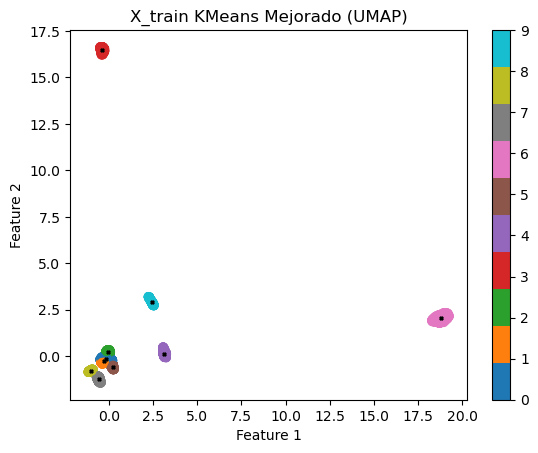

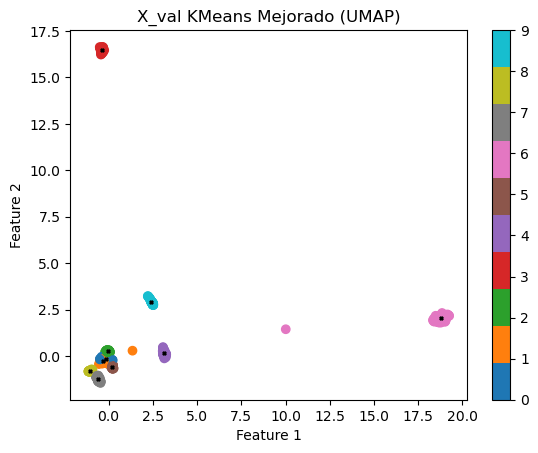

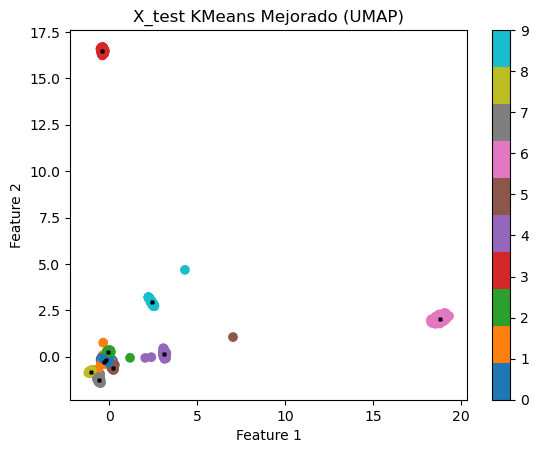

In [100]:
# Gráficas y métricas para el modelo KMeans
silhouette_train = silhouette_score(X_train_umap, kmeans_m_train_labels)
silhouette_val = silhouette_score(X_val_umap, kmeans_m_val_labels)
silhouette_val = silhouette_score(X_test_umap, kmeans_m_test_labels)
rand_index_train = adjusted_rand_score(Y_train[0], kmeans_m_train_labels)
rand_index_val = adjusted_rand_score(Y_val[0], kmeans_m_val_labels)

print(f"Silhouette Score for Training Data {silhouette_train}")
print(f"Silhouette Score for Validation Data: {silhouette_val}")
print(f"Silhouette Score for Test Data: {silhouette_val}")
print(f"Adjusted Rand Index for Training Data: {rand_index_train}")
print(f"Adjusted Rand Index for Validation Data: {rand_index_val}")

# Plot for X_train
fig = plt.figure()
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=kmeans_m_train_labels, cmap='tab10')
plt.title("X_train KMeans Mejorado (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.scatter(centroides_m_train[:, 0], centroides_m_train[:, 1], c='black', marker='X', s=5)
plt.show()


# Plot for X_val
fig = plt.figure()
plt.scatter(X_val_umap[:, 0], X_val_umap[:, 1], c=kmeans_m_val_labels, cmap='tab10')
plt.title("X_val KMeans Mejorado (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.scatter(centroides_m_train[:, 0], centroides_m_train[:, 1], c='black', marker='X', s=5)
plt.show()

# Plot for X_val
fig = plt.figure()
plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=kmeans_m_test_labels, cmap='tab10')
plt.title("X_test KMeans Mejorado (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.scatter(centroides_m_train[:, 0], centroides_m_train[:, 1], c='black', marker='X', s=5)
plt.show()

### Modelo 3: DBSCAN

In [52]:
from sklearn.neighbors import KDTree
from collections import Counter

NOISE = -1
UNDEFINED = -2

def dbscan(ds, radio, vecinos_min):
  tree = KDTree(ds)
  n, k = ds.shape
  marked_count = 0
  cluster = [UNDEFINED for _ in range(n)]
  cluster_count = -1

  stack = [0]
  while True:
    if len(stack) == 0:
      try:
        stack.append(cluster.index(UNDEFINED))
      except:
        return tree, cluster
    current_index = stack.pop()

    # sin marcar -> crear nuevo cluster
    if cluster[current_index] == UNDEFINED: # if unmarked
      marked_count += 1
      neighbors = tree.query_radius([ds[current_index]], radio)[0]
      n_neighbors = len(neighbors)
      if n_neighbors < vecinos_min: # ruido
        cluster[current_index] = NOISE
      else: # caso normal
        cluster_count += 1
        cluster[current_index] = cluster_count
        for v in neighbors:
          stack.append(v)
          cluster[v] = cluster_count
    # marcado
    else:
      neighbors = tree.query_radius([ds[current_index]], radio)[0]
      for v in neighbors:
        if cluster[v] == UNDEFINED:
          marked_count += 1
          stack.append(v)
          cluster[v] = cluster_count
        if cluster[v] == NOISE:
          cluster[v] = cluster_count

  return tree, cluster

def dbscan_predict(ds, tree, clusters, radio, vecinos_min, new_points):
    predicted_labels = []
    for point in new_points:
        neighbors = tree.query_radius([point], radio)[0]
        if len(neighbors) == 0:
            predicted_labels.append(NOISE)
        else:
            neighbor_clusters = [clusters[neighbor] for neighbor in neighbors if clusters[neighbor] != NOISE]
            if len(neighbor_clusters) == 0:
                predicted_labels.append(NOISE)
            else:
                most_common_cluster = Counter(neighbor_clusters).most_common(1)[0][0]
                predicted_labels.append(most_common_cluster)
    return predicted_labels

In [126]:
# Ejecución del modelo DBSCAN
r = 0.15
min_neighbors = 20
tree, dbscan_train_labels = dbscan(X_train_umap, r, min_neighbors)
dbscan_val_labels = dbscan_predict(X_train_umap, tree, dbscan_train_labels, r, min_neighbors, X_val_umap)
dbscan_test_labels = dbscan_predict(X_train_umap, tree, dbscan_train_labels, r, min_neighbors, X_test_umap)
print(np.unique(dbscan_train_labels, return_counts=True))
print(np.unique(dbscan_val_labels, return_counts=True))
print(np.unique(dbscan_test_labels, return_counts=True))

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]), array([  4, 780, 531, 479, 545, 468, 691, 575, 634, 266, 436]))
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]), array([10, 42, 37, 43, 42, 40, 44, 46, 41, 43, 38]))
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]), array([28, 83, 76, 84, 74, 75, 78, 69, 86, 78, 73]))


In [127]:
# Removiendo el ruido para calcular el silhouette score
X_train_noiseless = []
train_noiseless = []
for i in range(len(X_train_umap)):
    if dbscan_train_labels != NOISE:
        X_train_noiseless.append(X_train_umap[i])
        train_noiseless.append(dbscan_train_labels[i])

X_val_noiseless = []
val_noiseless = []
for i in range(len(X_val_umap)):
    if dbscan_val_labels != NOISE:
        X_val_noiseless.append(X_val_umap[i])
        val_noiseless.append(dbscan_val_labels[i])

X_test_noiseless = []
test_noiseless = []
for i in range(len(X_test_umap)):
    if dbscan_test_labels != NOISE:
        X_test_noiseless.append(X_test_umap[i])
        test_noiseless.append(dbscan_test_labels[i])

Silhouette Score for Training Data: 0.8545292019844055
Silhouette Score for Validation Data: 0.7989315986633301
Silhouette Score for Test Data: 0.7989315986633301
Adjusted Rand Index for Training Data: 0.9499769726658595
Adjusted Rand Index for Validation Data: 0.9169743063334658


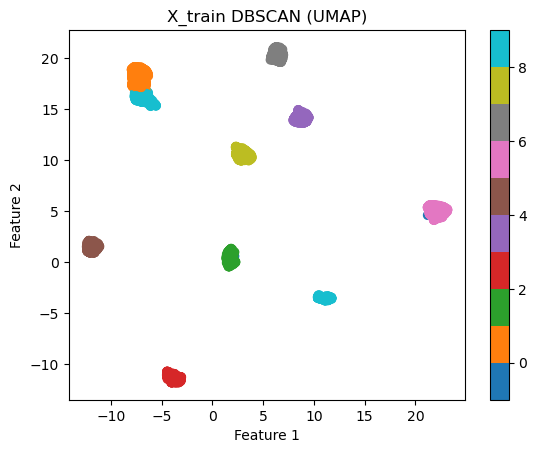

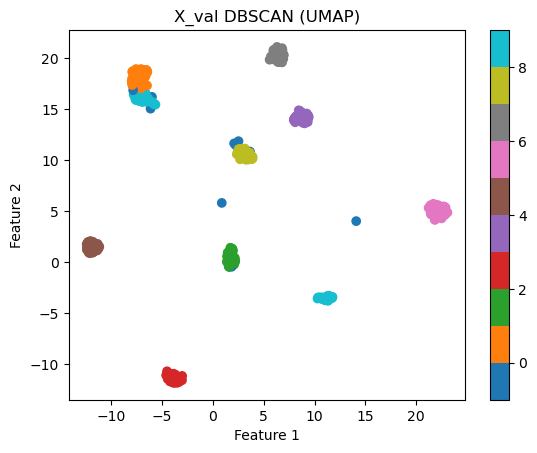

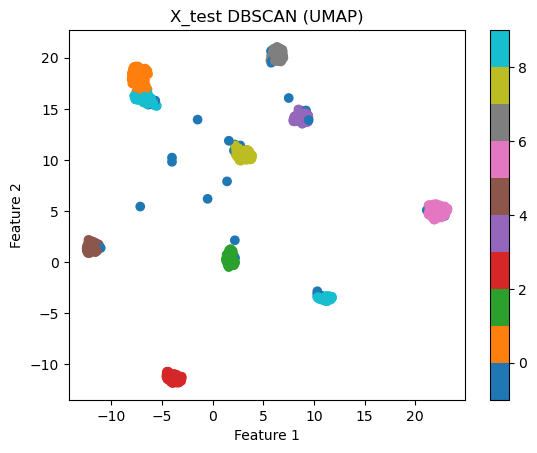

In [128]:
# Gráficas y métricas para el modelo DBSCAN
silhouette_train = silhouette_score(X_train_noiseless, train_noiseless)
silhouette_val = silhouette_score(X_val_noiseless, val_noiseless)
silhouette_val = silhouette_score(X_test_noiseless, test_noiseless)
rand_index_train = adjusted_rand_score(Y_train[0], dbscan_train_labels)
rand_index_val = adjusted_rand_score(Y_val[0], dbscan_val_labels)

print(f"Silhouette Score for Training Data: {silhouette_train}")
print(f"Silhouette Score for Validation Data: {silhouette_val}")
print(f"Silhouette Score for Test Data: {silhouette_val}")
print(f"Adjusted Rand Index for Training Data: {rand_index_train}")
print(f"Adjusted Rand Index for Validation Data: {rand_index_val}")

# Plot for X_train
fig = plt.figure()
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=dbscan_train_labels, cmap='tab10')
plt.title("X_train DBSCAN (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.show()


# Plot for X_val
fig = plt.figure()
plt.scatter(X_val_umap[:, 0], X_val_umap[:, 1], c=dbscan_val_labels, cmap='tab10')
plt.title("X_val DBSCAN (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.show()

# Plot for X_val
fig = plt.figure()
plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=dbscan_test_labels, cmap='tab10')
plt.title("X_test DBSCAN (UMAP)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.show()

## Submission

Archivo .csv para la competencia de Kaggle: https://www.kaggle.com/competitions/project-3-clustering

In [ ]:
kmeans_series = pd.Series([int(i) for i in kmeans_test_labels], name='label')
df_kmeans = pd.concat([test_ids, kmeans_series], axis=1)
df_kmeans.head()

In [102]:
kmeans_m_series = pd.Series([int(i) for i in kmeans_m_test_labels], name='label')
df_kmeans_m = pd.concat([test_ids, kmeans_m_series], axis=1)
print(len(df_kmeans_m))
if len(df_kmeans_m) < 805:
    # Find the missing youtube_id
    set1 = set(test_df['youtube_id'])
    set2 = set(df_kmeans_m['youtube_id'])
    missing_youtube_id = list(set1 - set2)
    new_row = pd.DataFrame({'youtube_id': missing_youtube_id, 'label': 0})

    # Append the new row to df
    df_kmeans_m = pd.concat([df_kmeans_m, new_row], ignore_index=True)
    print(len(df_kmeans_m))
df_kmeans_m.head()

804
805


,youtube_id,label
0,Tg1CoPWWr24,0
1,U4T7zVNeswc,0
2,J03k9nCxnZ0,6
3,CBh5okWSMNk,4
4,rFEPHGwno-4,0


In [103]:
output_csv = './submission_kmeans_m_2.csv'
write_to_csv = False:
if write_to_csv:
    df_kmeans_m.to_csv(output_csv, index=False)
    print(f"CSV con predicciones guardado en: {output_csv}")

CSV con predicciones guardado en: ./submission_kmeans_m_ig65m_2.csv
